# Pre Loading Libraries

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install tensorflow_hub
!pip install transformers
!pip install scikit-plot

     |████████████████████████████████| 4.9 MB 10.0 MB/s 
     |████████████████████████████████| 462 kB 68.4 MB/s 
     |████████████████████████████████| 2.2 MB 7.8 MB/s 
     |████████████████████████████████| 1.2 MB 62.4 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 1.1 MB 53.2 MB/s 
     |████████████████████████████████| 47.8 MB 54 kB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 636 kB 56.2 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 352 kB 48.5 MB/s 
     |████████████████████████████████| 237 kB 58.9 MB/s 
     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 6.3 MB/s 


In [2]:
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Data Loading & Exploration

In [5]:
df = pd.read_csv('train.csv')
display(df.head())
display(df.info())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

In [6]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

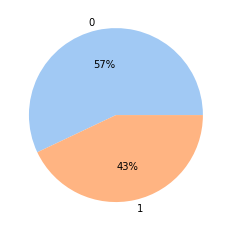

In [7]:
import seaborn as sns

#define data
data = [4342, 3271]
labels = ['0', '1']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


In [8]:
print(df['keyword'].unique())
print(df['location'].unique())


[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'droug

In [9]:
df = df.drop(['id', 'keyword','location'], axis = 1)
df.head()


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Data Cleaning

**Make Characters to Lower Case**

In [10]:
df["CleanText"] = df["text"].apply(lambda x: x.lower())
df.head()

,text,target,CleanText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


**Remove non-characters : URL,HTML,Emojis, punctuation, **

In [11]:
#remove URL

df["CleanText"] = df["CleanText"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "",x))


In [12]:
def removeHTML(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeHTML(x))


In [13]:
def removeEmojis(text):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["CleanText"] = df["CleanText"].apply(lambda x: removeEmojis(x))


In [14]:
def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [15]:
df["CleanText"] = df["CleanText"].apply(lambda x: RemovePunctuation(x))


In [16]:
def RemoveASCII(text):
  return re.sub(r'[^\x00-\x7f]', "", text)

df["CleanText"] = df["CleanText"].apply(lambda x: RemoveASCII(x))

In [17]:
df.head()


,text,target,CleanText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


#Data Preprocessing Part1 ([NLTK](https://www.nltk.org/index.html)) 

**Tokenizer**

In [18]:
df['TokenizedText'] = df['CleanText'].apply(nltk.word_tokenize)
df.head()


,text,target,CleanText,TokenizedText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


**Remove Stopwords**

In [19]:
stop = set(stopwords.words('english'))
df['RemoveStopWords'] = df['TokenizedText'].apply(lambda x: [word for word in x if word not in stop])
df.head()


,text,target,CleanText,TokenizedText,RemoveStopWords
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


**PorterStemmer**

What is PorterStemmer in NLP?
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

In [20]:
def doPorterStemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

df['PorterStemmer'] = df['RemoveStopWords'].apply(lambda x: doPorterStemmer(x))
df.head()

,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


**WordNetLemmatizer**

In [21]:
def doLemmatizeWord(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in text]
    return lemma

df['LemmatizedText'] = df['RemoveStopWords'].apply(lambda x: doLemmatizeWord(x))
df.head()


,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [22]:
df['FINAL']=df['LemmatizedText'].apply(lambda x: ''.join(i+' ' for i in x))
df.head()

,text,target,CleanText,TokenizedText,RemoveStopWords,PorterStemmer,LemmatizedText,FINAL
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


#Data PreProcessing Part2 to transform text to Numerical data


**We will make three different numerical datasets**

**Bag Of Words using CounterVector**

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range = (1,1))
cv_df = vectorizer.fit_transform(df['FINAL'])

vectorizer.get_feature_names_out()
print(cv_df.shape)

(7613, 16270)


**TF-IDF**


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(ngram_range = (1,2))
tfidf_df = tfvectorizer.fit_transform(df['FINAL'])
print(tfidf_df.shape)


(7613, 63245)


**Word2Vec**

In [26]:
from gensim.models import Word2Vec, KeyedVectors
import nltk
import multiprocessing

In [28]:
sentences = df['FINAL'].values
sentences = [nltk.word_tokenize(title) for title in sentences]
#print(sentences)

In [29]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer


w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)


In [31]:
w2v_model.build_vocab(sentences, progress_per=10000)
#As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:
#w2v_model.init_sims(replace=True)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(1441465, 2133030)

In [32]:
w2v_model.wv.similarity("fire", 'wildfire')


0.9796162

In [33]:
w2v_model.wv.most_similar(positive=["evacuation"])


[('faan', 0.9996593594551086),
 ('order', 0.999569296836853),
 ('noted', 0.999382734298706),
 ('town', 0.9993628263473511),
 ('interesting', 0.9993455410003662),
 ('ultimatum', 0.9993442296981812),
 ('lifted', 0.9993436932563782),
 ('floated', 0.9992890954017639),
 ('cabin', 0.9992789030075073),
 ('almost', 0.9992769956588745)]

In [34]:
w2v_model.wv.most_similar(positive=["injury"])


[('ear', 0.9998250603675842),
 ('neither', 0.9998244047164917),
 ('nobody', 0.9998230934143066),
 ('bottom', 0.9998220205307007),
 ('wee', 0.9998218417167664),
 ('bound', 0.9998217225074768),
 ('ill', 0.9998217225074768),
 ('thanks', 0.9998207092285156),
 ('everyones', 0.9998204708099365),
 ('throwing', 0.9998204708099365)]

In [36]:
#words = list(w2v_model.wv.vocab)
#print(words) 

In [37]:
w2v_df = []
for sent in sentences:
    vw = np.zeros(300) 
    #one sentence has many words
    for word in sent:
        vw += w2v_model[word]
    #average
    vw = vw/len(sent)
    w2v_df.append(np.array(vw))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [41]:
print(len(w2v_df))
#print(w2v_model['earthquake'])

7613


# Reduce Dimension PCA 

In [42]:
from sklearn.preprocessing import StandardScaler
'''ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.'''
from sklearn.decomposition import PCA
'''TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.'''
from sklearn.decomposition import TruncatedSVD
'''
trans_cv_df = StandardScaler(with_mean=False).fit_transform(cv_df)

#reduce dimention half
svd = TruncatedSVD(n_components=100)
svd_trans_cv_df = svd.fit_transform(trans_cv_df)

print(svd_trans_cv_df.shape)
'''

(7613, 100)


In [43]:

'''trans_tfidf_df = StandardScaler(with_mean=False).fit_transform(tfidf_df)
#reduce dimention half
svd = TruncatedSVD(n_components=100)
svd_trans_tfidf_df = svd.fit_transform(trans_tfidf_df)

print(svd_trans_tfidf_df.shape)'''


(7613, 100)


In [44]:
trans_w2v_df = StandardScaler().fit_transform(w2v_df)

#reduce dimention half
pca = PCA(n_components=100)
pca_trans_w2v_df = pca.fit_transform(trans_w2v_df)

print(pca_trans_w2v_df.shape)

(7613, 100)


# Data Split

In [46]:
from sklearn.model_selection import train_test_split

cv_train_X, cv_test_X, cv_train_Y, cv_test_y = train_test_split(cv_df, df['target'], test_size=0.30, random_state=17)
#svd_cv_train_X, svd_cv_test_X, svd_cv_train_Y, svd_cv_test_y = train_test_split(svd_trans_cv_df, df['target'], test_size=0.30, random_state=17)

tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y = train_test_split(tfidf_df, df['target'], test_size=0.30, random_state=17)
#svd_tfidf_train_X, svd_tfidf_test_X, svd_tfidf_train_Y, svd_tfidf_test_y = train_test_split(svd_trans_tfidf_df, df['target'], test_size=0.30, random_state=17)

w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y = train_test_split(w2v_df, df['target'], test_size=0.30, random_state=17)
pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y = train_test_split(pca_trans_w2v_df, df['target'], test_size=0.30, random_state=17)

# Model - SVM

In [66]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

 
def model_SVM(train_X, test_X, train_y, test_y) :
  SVM = svm.SVC()
  SVM.fit(train_X, train_y)
  pred_y = SVM.predict(test_X)

  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))

**Training three datasets on Basic SVM and Prediction/Accuracy**

In [67]:
model_SVM(cv_train_X, cv_test_X, cv_train_Y, cv_test_y)
#model_SVM(svd_cv_train_X, svd_cv_test_X, svd_cv_train_Y, svd_cv_test_y)

model_SVM(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
#model_SVM(svd_tfidf_train_X, svd_tfidf_test_X, svd_tfidf_train_Y, svd_tfidf_test_y)

model_SVM(w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y)
model_SVM(pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y)

accuracy_score: 0.799
accuracy_score: 0.761
accuracy_score: 0.629
accuracy_score: 0.711


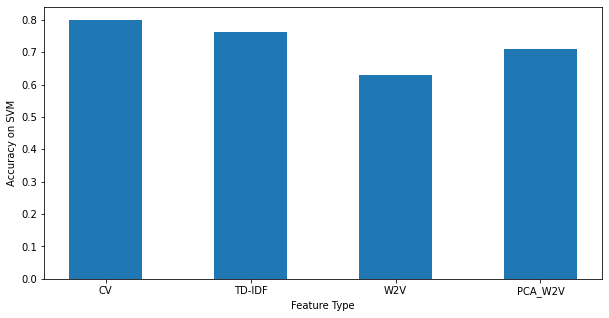

In [100]:
data = {'CV':0.799, 'TD-IDF':0.761, 'W2V':0.629,'PCA_W2V':0.711}
datatype = list(data.keys())
acc = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(datatype, acc, width = 0.5)
 
plt.xlabel("Feature Type")
plt.ylabel("Accuracy on SVM")
plt.show()

**SVM with CounterVector has higher accuracy**

accuracy_score: 0.800
Recall: 0.668
Precision: 0.839
F1 Score: 0.744


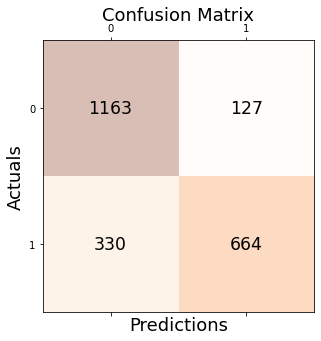

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def testModel(train_x, test_x, train_y, test_y, _c, _gam, _kn):
  SVM = svm.SVC(kernel=_kn, C=_c)
  SVM.fit(train_x, train_y)
  pred_y = SVM.predict(test_x)
  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))
  print('Recall: %.3f' % recall_score(test_y, pred_y))
  print('Precision: %.3f' % precision_score(test_y, pred_y))
  print('F1 Score: %.3f' % f1_score(test_y, pred_y))


  conf_matrix = confusion_matrix(y_true=test_y, y_pred=pred_y)
  #
  # Print the confusion matrix using Matplotlib
  #
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()


'''
To find best tuning option

group_c = [5, 1, 0.1, 0.05, 0.01, 0.001]
group_gam = [5, 1, 0.1, 0.05, 0.01, 0.001]

for c in group_c:
  print("C value:", c)
  for gam in group_gam:
    print("gam value:", gam)
    testModel(cv_train_X, cv_test_X, cv_train_Y, cv_test_y, c, gam, 'rbf')
'''
#testModel(cv_train_X, cv_test_X, cv_train_Y, cv_test_y, c, gam, 'linear')
#testModel(cv_train_X, cv_test_X, cv_train_Y, cv_test_y, c, gam, 'rbf')
#testModel(cv_train_X, cv_test_X, cv_train_Y, cv_test_y, 1, 'auto', 'poly')

testModel(cv_train_X, cv_test_X, cv_train_Y, cv_test_y, 1, 'auto', 'sigmoid')

# *LogisticRegression*

In [70]:
from sklearn.linear_model import LogisticRegression

def model_Logistic(train_X, test_X, train_y, test_y) :
  logisticRegr = LogisticRegression()
  logisticRegr.fit(train_X, train_y)
  pred_y = logisticRegr.predict(test_X)

  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))

In [71]:
model_Logistic(cv_train_X, cv_test_X, cv_train_Y, cv_test_y)
model_Logistic(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
model_Logistic(w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y)
model_Logistic(pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y)

accuracy_score: 0.797
accuracy_score: 0.776
accuracy_score: 0.667
accuracy_score: 0.764


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


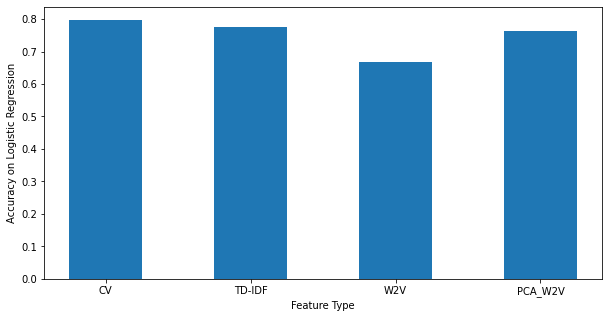

In [101]:
data = {'CV':0.797, 'TD-IDF':0.776, 'W2V':0.667,'PCA_W2V':0.764}
datatype = list(data.keys())
acc = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(datatype, acc, width = 0.5)
 
plt.xlabel("Feature Type")
plt.ylabel("Accuracy on Logistic Regression")
plt.show()

**LogitricRegression with CountVector has better accuracy**

In [73]:
#cv_train_X, cv_test_X, cv_train_Y, cv_test_y

'''
To find best tuning option

'''
group_c = [10, 5, 1, 0.1, 0.001]

for c in group_c:
    logistic_lasso = LogisticRegression(C=c, penalty='l1', tol=0.001, solver='saga', random_state=42,  max_iter=10000) #lasso
    logistic_ridge = LogisticRegression(C=c, penalty='l2', tol=0.001, solver='saga', random_state=42, max_iter=10000)  #Ridge 
    l_ela = LogisticRegression(C=c, penalty='elasticnet', solver='saga', l1_ratio=0.5, tol=0.001, max_iter=10000)
    
    logistic_lasso.fit(cv_train_X, cv_train_Y.values.ravel())
    logistic_ridge.fit(cv_train_X, cv_train_Y.values.ravel())
    l_ela.fit(cv_train_X, cv_train_Y.values.ravel())
    
    coef_l1_LR = logistic_lasso.coef_.ravel()
    coef_l2_LR = logistic_ridge.coef_.ravel()
    coef_ela_LR = l_ela.coef_.ravel()
    
    # coef_l1_LR contains zeros due to the L1 sparsity inducing norm
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100 
    sparsity_l_ela = np.mean(coef_ela_LR == 0) * 100 

    print("\n C=%.5f" % c)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Ela penalty:", sparsity_l_ela))
    print("{:<40} {:.3f}".format("Score with L1 penalty:", logistic_lasso.score(cv_test_X, cv_test_y.values.ravel())))  #lasso score
    print("{:<40} {:.3f}".format("Score with L2 penalty:",logistic_ridge.score(cv_test_X, cv_test_y.values.ravel())))   #ridge score
    print("{:<40} {:.3f}".format("Score with Ela penalty:",l_ela.score(cv_test_X, cv_test_y.values.ravel())))   #elastic score


 C=10.00000
Sparsity with L1 penalty:                53.47%
Sparsity with L2 penalty:                20.19%
Sparsity with Ela penalty:               38.22%
Score with L1 penalty:                   0.78
Score with L2 penalty:                   0.78
Score with Ela penalty:                  0.78

 C=5.00000
Sparsity with L1 penalty:                68.21%
Sparsity with L2 penalty:                20.19%
Sparsity with Ela penalty:               49.48%
Score with L1 penalty:                   0.78
Score with L2 penalty:                   0.79
Score with Ela penalty:                  0.79

 C=1.00000
Sparsity with L1 penalty:                93.60%
Sparsity with L2 penalty:                20.19%
Sparsity with Ela penalty:               81.09%
Score with L1 penalty:                   0.78
Score with L2 penalty:                   0.79
Score with Ela penalty:                  0.79

 C=0.10000
Sparsity with L1 penalty:                99.52%
Sparsity with L2 penalty:                20.19%
Sparsity 

accuracy_score: 0.797
Recall: 0.693
Precision: 0.813
F1 Score: 0.749


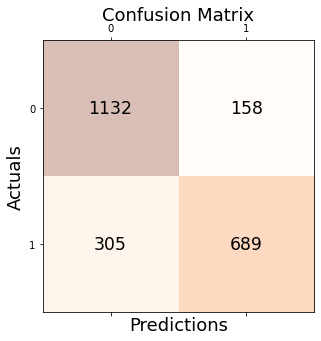

In [74]:
''' BEST OPTION'''
#cv_train_X, cv_test_X, cv_train_Y, cv_test_y

logisticRegr = LogisticRegression()
logisticRegr.fit(cv_train_X, cv_train_Y)
pred_y = logisticRegr.predict(cv_test_X)
#Accuracy
print('accuracy_score: %.3f' % accuracy_score(cv_test_y, pred_y))
print('Recall: %.3f' % recall_score(cv_test_y, pred_y))
print('Precision: %.3f' % precision_score(cv_test_y, pred_y))
print('F1 Score: %.3f' % f1_score(cv_test_y, pred_y))


conf_matrix = confusion_matrix(y_true=cv_test_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


# DecisionTree

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def model_DT (train_X, test_X, train_y, test_y) :
  clf = DecisionTreeClassifier()
  clf.fit(train_X, train_y)
  pred_y = clf.predict(test_X)
  #Accuracy
  print('accuracy_score: %.3f' % accuracy_score(test_y, pred_y))


In [77]:
model_DT(cv_train_X, cv_test_X, cv_train_Y, cv_test_y)
model_DT(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
model_DT(w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y)
model_DT(pca_w2v_train_X, pca_w2v_test_X, pca_w2v_train_Y, pca_w2v_test_y)

accuracy_score: 0.749
accuracy_score: 0.753
accuracy_score: 0.656
accuracy_score: 0.679


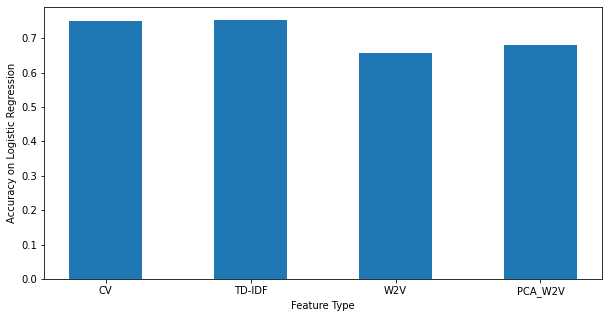

In [102]:
data = {'CV':0.749, 'TD-IDF':0.753, 'W2V':0.656,'PCA_W2V':0.679}
datatype = list(data.keys())
acc = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(datatype, acc, width = 0.5)
 
plt.xlabel("Feature Type")
plt.ylabel("Accuracy on Logistic Regression")
plt.show()

**Decision Tree with Td-Idf is higher accuracy.**

In [86]:
def test_dt(x_train, x_test, y_train, y_test) :
    print()
    for c_depth in [2, 4, 6, 8, 10, 12, 20, 30, None] : 
        print("model selection depth = {0}".format(c_depth))
        clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=c_depth)
        clf_gini.fit(x_train, y_train)
        y_pred = clf_gini.predict(x_test)
        print(accuracy_score(y_test, y_pred))

test_dt(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)


model selection depth = 2
0.5923817863397548
model selection depth = 4
0.6072679509632224
model selection depth = 6
0.6287215411558669
model selection depth = 8
0.6453590192644484
model selection depth = 10
0.6545534150612959
model selection depth = 12
0.6650612959719789
model selection depth = 20
0.7044658493870403
model selection depth = 30
0.7342381786339754
model selection depth = None
0.7513134851138353


accuracy_score: 0.751
Recall: 0.678
Precision: 0.730
F1 Score: 0.703


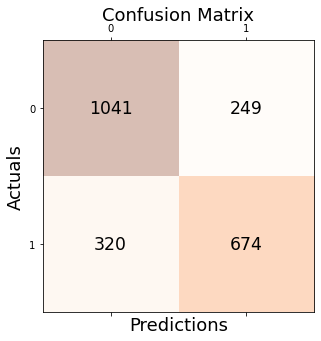

In [88]:
#test_dt(tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y)
'''
def __init__(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
'''


clf = DecisionTreeClassifier()
clf.fit(tfidf_train_X, tfidf_train_Y)
pred_y = clf.predict(tfidf_test_X)

#Accuracy
print('accuracy_score: %.3f' % accuracy_score(tfidf_test_y, pred_y))
print('Recall: %.3f' % recall_score(tfidf_test_y, pred_y))
print('Precision: %.3f' % precision_score(tfidf_test_y, pred_y))
print('F1 Score: %.3f' % f1_score(tfidf_test_y, pred_y))


conf_matrix = confusion_matrix(y_true=tfidf_test_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


# RandomTree (NOT YET)

# AdaBoostClassifier (NOT YET)

# Ensemble Method (SVM, LogisticRegr, DecistionTree)

**CountVector**

Hard Voting Score 0.803
Recall: 0.678
Precision: 0.730
F1 Score: 0.703


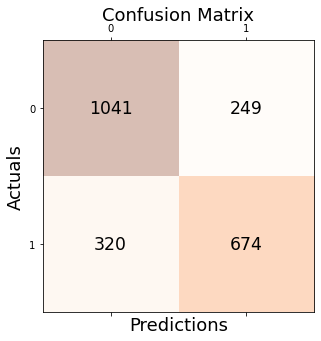

Soft Voting Score  0


In [94]:

'''
cv_train_X, cv_test_X, cv_train_Y, cv_test_y = train_test_split(cv_df, df['target'], test_size=0.30, random_state=17)
'''

ensembleModels = []
ensembleModels.append(('LR',  LogisticRegression()))
ensembleModels.append(('SVM', svm.SVC(kernel='sigmoid',probability = True)))
ensembleModels.append(('DT', DecisionTreeClassifier()))
  
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = ensembleModels, voting ='hard')
vot_hard.fit(cv_train_X, cv_train_Y)
y_pred = vot_hard.predict(cv_test_X)
  
# using accuracy_score metric to predict accuracy
score = accuracy_score(cv_test_y, y_pred)
print("Hard Voting Score %.3f" % score)
print('Recall: %.3f' % recall_score(cv_test_y, pred_y))
print('Precision: %.3f' % precision_score(cv_test_y, pred_y))
print('F1 Score: %.3f' % f1_score(cv_test_y, pred_y))

conf_matrix = confusion_matrix(y_true=cv_test_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
  
# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = ensembleModels, voting ='soft')
vot_soft.fit(cv_train_X, cv_train_Y)
y_pred = vot_soft.predict(cv_test_X)
  
# using accuracy_score
score = accuracy_score(cv_test_y, y_pred)
print("Soft Voting Score % d" % score)

**TF-IDF**

Hard Voting Score 0.793
Recall: 0.678
Precision: 0.730
F1 Score: 0.703


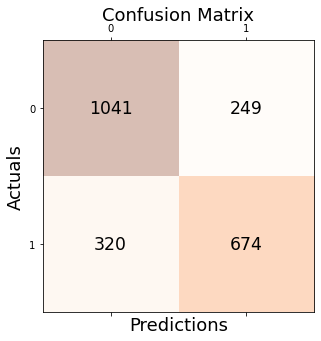

Soft Voting Score  0


In [96]:

'''
tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_y = train_test_split(tfidf_df, df['target'], test_size=0.30, random_state=17)
'''

ensembleModels = []
ensembleModels.append(('LR',  LogisticRegression()))
ensembleModels.append(('SVM', svm.SVC(kernel='sigmoid',probability = True)))
ensembleModels.append(('DT', DecisionTreeClassifier()))
  
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = ensembleModels, voting ='hard')
vot_hard.fit(tfidf_train_X, tfidf_train_Y)
y_pred = vot_hard.predict(tfidf_test_X)
  
# using accuracy_score metric to predict accuracy
score = accuracy_score(tfidf_test_y, y_pred)
print("Hard Voting Score %.3f" % score)
print('Recall: %.3f' % recall_score(tfidf_test_y, pred_y))
print('Precision: %.3f' % precision_score(tfidf_test_y, pred_y))
print('F1 Score: %.3f' % f1_score(tfidf_test_y, pred_y))

conf_matrix = confusion_matrix(y_true=tfidf_test_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
  
# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = ensembleModels, voting ='soft')
vot_soft.fit(tfidf_train_X, tfidf_train_Y)
y_pred = vot_soft.predict(tfidf_test_X)
  
# using accuracy_score
score = accuracy_score(tfidf_test_y, y_pred)
print("Soft Voting Score % d" % score)

Hard Voting Score 0.666
Recall: 0.678
Precision: 0.730
F1 Score: 0.703


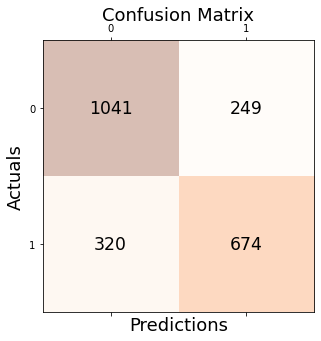

Soft Voting Score  0


In [103]:

'''
w2v_train_X, w2v_test_X, w2v_train_Y, w2v_test_y = train_test_split(w2v_df, df['target'], test_size=0.30, random_state=17)
'''

ensembleModels = []
ensembleModels.append(('LR',  LogisticRegression()))
ensembleModels.append(('SVM', svm.SVC(kernel='sigmoid',probability = True)))
ensembleModels.append(('DT', DecisionTreeClassifier()))
  
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = ensembleModels, voting ='hard')
vot_hard.fit(w2v_train_X, w2v_train_Y)
y_pred = vot_hard.predict(w2v_test_X)
  
# using accuracy_score metric to predict accuracy
score = accuracy_score(w2v_test_y, y_pred)
print("Hard Voting Score %.3f" % score)
print('Recall: %.3f' % recall_score(w2v_test_y, pred_y))
print('Precision: %.3f' % precision_score(w2v_test_y, pred_y))
print('F1 Score: %.3f' % f1_score(w2v_test_y, pred_y))

conf_matrix = confusion_matrix(y_true=w2v_test_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
  
# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = ensembleModels, voting ='soft')
vot_soft.fit(w2v_train_X, w2v_train_Y)
y_pred = vot_soft.predict(w2v_test_X)
  
# using accuracy_score
score = accuracy_score(w2v_test_y, y_pred)
print("Soft Voting Score % d" % score)